# AlphaLink2 Notebook

This notebook allows the user to integrate crosslinking MS data directly into [AlphaFold-Multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1) to guide the prediction by extending [Uni-Fold](https://github.com/dptech-corp/Uni-Fold). Please note that this notebook represents a simplified pipeline which is also much more size limited. For best results, run [AlphaLink2](https://github.com/Rappsilber-Laboratory/AlphaLink2) locally.

The homology search process in this notebook is enabled with the [MMSeqs2](https://github.com/soedinglab/MMseqs2.git) server provided by [ColabFold](https://github.com/sokrypton/ColabFold).


**Licenses**

This Colab uses the [AlphaLink2 model parameters](https://github.com/Rappsilber-Laboratory/AlphaLink2/tree/main#model-parameters-license) and its outputs are under the terms of the Creative Commons Attribution 4.0 International (CC BY 4.0) license. You can find details at: https://creativecommons.org/licenses/by/4.0/legalcode. The Colab itself is provided under the [Apache 2.0 license](https://www.apache.org/licenses/LICENSE-2.0).


**Citations**

Please cite the following papers if you use this notebook:

*   Kolja Stahl, Oliver Brock, Juri Rappsilber. "[Modelling protein complexes with crosslinking mass spectrometry and deep learning](https://www.biorxiv.org/content/10.1101/2023.06.07.544059v3)" bioRxiv (2023)
*   Ziyao Li, Xuyang Liu, Weijie Chen, Fan Shen, Hangrui Bi, Guolin Ke, Linfeng Zhang. "[Uni-Fold: An Open-Source Platform for Developing Protein Folding Models beyond AlphaFold.](https://www.biorxiv.org/content/10.1101/2022.08.04.502811v1)" bioRxiv (2022)
*   Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S and Steinegger M. "[ColabFold: Making protein folding accessible to all.](https://www.nature.com/articles/s41592-022-01488-1)" Nature Methods (2022)

**Acknowledgements**

AlphaLink2 integrates crosslinking MS data into the [Uni-Fold](https://github.com/dptech-corp/Uni-Fold) which is largely based on [AlphaFold](https://doi.org/10.1038/s41586-021-03819-2) and [AlphaFold-Multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). The design of this notebook refers directly to [ColabFold](https://www.nature.com/articles/s41592-022-01488-1).

In [1]:
#@title Provide the arguments here and hit `Run` -> `Run All Cells`
jobname = 'alphalink_colab' #@param {type:"string"}

model_weights = "2.2 (trained on 25A CA-CA)" #@param ["2.2 (trained on 25A CA-CA)","2.3 (trained on 25A CA-CA) (experimental)","2.2 (trained on 10A CA-CA) (experimental)"]

#@markdown Parameters for MSA searching with MMseqs2.

use_templates = True #@param {type:"boolean"}
msa_mode = "MMseqs2" #@param ["MMseqs2","single_sequence"]

#@markdown Parameters for model inference.

max_recycling_iters = 3 #@param {type:"integer"}
num_ensembles = 1 #@param {type:"integer"}
manual_seed = 42 #@param {type:"integer"}
times = 1 #@param {type:"integer"}

#@markdown Plotting parameters.

show_sidechains = False #@param {type:"boolean"}
dpi = 100 #@param {type:"integer"}
crosslink_distance_cutoff = 35 #@param {type:"integer"}

In [2]:
#@title Install AlphaLink2 and third-party softwares
#@markdown Please execute this cell by pressing the _Play_ button
#@markdown on the left to download and import third-party software
#@markdown in this Colab notebook. (See the [acknowledgements](https://github.com/Rappsilber-Laboratory/AlphaLink2/tree/main#acknowledgements) in our readme.)

#@markdown Re-run this cell if you switch network weights.


#@markdown **Note**: This installs the software on the Colab
#@markdown notebook in the cloud and not on your computer.


%%bash -s "$model_weights"
if [ ! -f ENV_READY ]; then
    apt-get update && DEBIAN_FRONTEND=noninteractive apt-get install -y -qq kalign

    # Install HHsuite.
    wget -q https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-AVX2-Linux.tar.gz; tar xfz hhsuite-3.3.0-AVX2-Linux.tar.gz; ln -s $(pwd)/bin/* /usr/bin

    pip3 -q install py3dmol gdown

    pip3 -q install libmsym

    pip3 -q install biopython==1.81

    touch ENV_READY
fi

GIT_REPO='https://github.com/Rappsilber-Laboratory/AlphaLink2'
UNICORE_URL='https://github.com/Rappsilber-Laboratory/AlphaLink2/raw/refs/heads/main/notebooks/unicore-0.0.1-py3-none-any.whl'
PARAM_URL_v2='https://tubcloud.tu-berlin.de/s/R8AHGJsdy4d5tqa/download'
PARAM_URL_v3='https://tubcloud.tu-berlin.de/s/exJkwrxoRdz8wds/download'
PARAM_URL_10A='https://tubcloud.tu-berlin.de/s/XKcNeYM2WjBC7ZT/download'

if [ ! -f UNIFOLD_READY ]; then
    wget  ${UNICORE_URL}
    pip3 -q install "unicore-0.0.1-py3-none-any.whl"
    git clone -b main ${GIT_REPO}
    pip3 -q install ./AlphaLink2
    # wget --content-disposition -O alphalink_weights.pt ${PARAM_URL}

    touch UNIFOLD_READY
fi

rm alphalink_weights.pt

if [ "$1" = "2.2 (trained on 25A CA-CA)" ]; then
    if [ ! -f alphalink_weights_v2.pt ]; then
        echo "downloading "$1" weights"
        wget --content-disposition -O alphalink_weights_v2.pt ${PARAM_URL_v2}
    fi
    ln -s alphalink_weights_v2.pt alphalink_weights.pt
elif [ "$1" = "2.2 (trained on 10A CA-CA) (experimental)" ]; then
    if [ ! -f alphalink_weights_v2_10A.pt ]; then
        echo "downloading "$1" weights"
        wget --content-disposition -O alphalink_weights_v2_10A.pt ${PARAM_URL_10A}
    fi
    ln -s alphalink_weights_v2_10A.pt alphalink_weights.pt
else
    if [ ! -f alphalink_weights_v3.pt ]; then
        echo "downloading "$1" weights"
        wget --content-disposition -O alphalink_weights_v3.pt ${PARAM_URL_v3}
    fi
    ln -s alphalink_weights_v3.pt alphalink_weights.pt
fi

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,149 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packag

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
--2025-11-19 14:54:55--  https://github.com/Rappsilber-Laboratory/AlphaLink2/raw/refs/heads/main/notebooks/unicore-0.0.1-py3-none-any.whl
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Rappsilber-Laboratory/AlphaLink2/refs/heads/main/notebooks/unicore-0.0.1-py3-none-any.whl [following]
--2025-11-19 14:54:55--  https://raw.githubusercontent.com/Rappsilber-Laboratory/AlphaLink2/refs/heads/main/notebooks/unicore-0.0.1-py3-none-any.whl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:4

In [3]:
#@title Load FASTA file
#@markdown Please execute this cell by pressing the _Play_ button
#@markdown on the left to upload the FASTA file.

from google.colab import files
from unifold.colab.data import load_fasta

sequences = files.upload()

if not len(sequences) == 1:
    raise ValueError('Please only upload a single FASTA file.')

input_sequences, descriptions = load_fasta(list(sequences.keys())[0],jobname)

fused_multi_tensor is not installed corrected
fused_rounding is not installed corrected
fused_layer_norm is not installed corrected
fused_rms_norm is not installed corrected
fused_softmax is not installed corrected


Saving al2_all_AlphaLink2.fasta to al2_all_AlphaLink2.fasta


In [4]:
#@title Load crosslinks
#@markdown Please execute this cell by pressing the _Play_ button
#@markdown on the left to upload the crosslink data as a CSV file.

#@markdown The crosslinks CSV has the following format (residues are 1-indexed, whitespace separated).

#@markdown residueFrom chain1 residueTo chain2 FDR

#@markdown Example:
#@markdown ```
#@markdown 1 A 50 B 0.2
#@markdown 5 A 5 A 0.1
#@markdown ```

#@markdown The chains are enumerated from A,B,... according to the sequence order in the FASTA file.

from google.colab import files
crosslinks = files.upload()

if not len(crosslinks) == 1:
    raise ValueError('Please only upload a single CSV file.')

from unifold.colab.data import load_crosslinks
import pickle
import gzip

fname = list(crosslinks.keys())[0]

crosslinks = load_crosslinks(fname)

pickle.dump(
    crosslinks,
    gzip.GzipFile('crosslinks.pkl.gz', 'wb'),
    protocol=4,
)

import os
os.remove(fname)

Saving al2_all_AlphaLink2.txt to al2_all_AlphaLink2.txt


In [5]:
#@title Generate MSAs and templates with MMseqs2
import os
import re
import random
import hashlib
import numpy as np
from pathlib import Path
from unifold.colab.data import validate_input
from unifold.msa.utils import divide_multi_chains

import pickle
import gzip
from unifold.msa import parsers
from unifold.msa import pipeline
from unifold.data.utils import compress_features
from unifold.data.protein import PDB_CHAIN_IDS
from unifold.colab.mmseqs import get_msa_and_templates

MIN_SINGLE_SEQUENCE_LENGTH = 6
MAX_SINGLE_SEQUENCE_LENGTH = 3000
MAX_MULTIMER_LENGTH = 3000

output_dir_base = "./prediction"
os.makedirs(output_dir_base, exist_ok=True)


def add_hash(x,y):
    return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

basejobname = "".join(input_sequences)
basejobname = re.sub(r'\W+', '', basejobname)
target_id = add_hash(jobname, basejobname)

# Validate the input.
sequences, is_multimer, symmetry_group = validate_input(
    input_sequences=input_sequences,
    symmetry_group='C1',
    min_length=MIN_SINGLE_SEQUENCE_LENGTH,
    max_length=MAX_SINGLE_SEQUENCE_LENGTH,
    max_multimer_length=MAX_MULTIMER_LENGTH)

result_dir = Path(output_dir_base)
output_dir = os.path.join(output_dir_base, target_id)

if is_multimer:
    divide_multi_chains(target_id, output_dir, sequences, descriptions)

s = []
for des, seq in zip(descriptions, sequences):
    s += [des, seq]

unique_sequences = []
[unique_sequences.append(x) for x in sequences if x not in unique_sequences]

if len(unique_sequences)==1:
    homooligomers_num = len(sequences)
else:
    homooligomers_num = 1

with open(f"{jobname}.fasta", "w") as f:
    f.write("\n".join(s))



(
  unpaired_msa,
  paired_msa,
  template_results,
) = get_msa_and_templates(
  target_id,
  sequences,
  result_dir=result_dir,
  msa_mode=msa_mode,
  use_templates=use_templates,
  homooligomers_num = homooligomers_num
)

for idx, seq in enumerate(sequences):
    chain_id = PDB_CHAIN_IDS[idx]
    sequence_features = pipeline.make_sequence_features(
              sequence=seq, description=f'> {jobname} seq {chain_id}', num_res=len(seq)
          )
    monomer_msa = parsers.parse_a3m(unpaired_msa[idx])
    msa_features = pipeline.make_msa_features([monomer_msa])
    template_features = template_results[idx]
    feature_dict = {**sequence_features, **msa_features, **template_features}
    feature_dict = compress_features(feature_dict)
    features_output_path = os.path.join(
            output_dir, "{}.feature.pkl.gz".format(chain_id)
        )
    pickle.dump(
        feature_dict,
        gzip.GzipFile(features_output_path, "wb"),
        protocol=4
        )
    if is_multimer:
        multimer_msa = parsers.parse_a3m(paired_msa[idx])
        pair_features = pipeline.make_msa_features([multimer_msa])
        pair_feature_dict = compress_features(pair_features)
        uniprot_output_path = os.path.join(
            output_dir, "{}.uniprot.pkl.gz".format(chain_id)
        )
        pickle.dump(
            pair_feature_dict,
            gzip.GzipFile(uniprot_output_path, "wb"),
            protocol=4,
        )


/usr/local/lib/python3.12/dist-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(


Using the single-chain model.


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


In [6]:
#@title AlphaLink2 prediction on GPU.

from unifold.colab.model import colab_inference

best_result = colab_inference(
    target_id=target_id,
    data_dir=output_dir,
    param_dir=".",
    output_dir=output_dir,
    is_multimer=is_multimer,
    max_recycling_iters=max_recycling_iters,
    num_ensembles=num_ensembles,
    times=times,
    manual_seed=manual_seed,
    device="cuda:0",                # do not change this on colab.
)


start to load params ./alphalink_weights.pt
start to predict alphalink_colab_11470


/usr/local/lib/python3.12/dist-packages/unicore/utils.py:381: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return data[ranges]


using 27 crosslink(s)
{'aatype': torch.Size([1, 1, 1372]), 'residue_index': torch.Size([1, 1, 1372]), 'seq_length': torch.Size([1, 1]), 'msa_chains': torch.Size([4, 1, 508, 1]), 'template_aatype': torch.Size([1, 1, 4, 1372]), 'template_all_atom_mask': torch.Size([1, 1, 4, 1372, 37]), 'template_all_atom_positions': torch.Size([1, 1, 4, 1372, 37, 3]), 'asym_id': torch.Size([1, 1, 1372]), 'sym_id': torch.Size([1, 1, 1372]), 'entity_id': torch.Size([1, 1, 1372]), 'num_sym': torch.Size([1, 1, 1372]), 'assembly_num_chains': torch.Size([1, 1, 1]), 'cluster_bias_mask': torch.Size([1, 1, 508]), 'bert_mask': torch.Size([4, 1, 508, 1372]), 'msa_mask': torch.Size([4, 1, 508, 1372]), 'asym_len': torch.Size([1, 1, 1]), 'xl': torch.Size([1, 1, 1372, 1372, 1]), 'num_recycling_iters': torch.Size([1, 1]), 'is_distillation': torch.Size([4, 1]), 'seq_mask': torch.Size([1, 1, 1372]), 'msa_row_mask': torch.Size([4, 1, 508]), 'template_mask': torch.Size([1, 1, 4]), 'template_pseudo_beta': torch.Size([1, 1, 4

/usr/local/lib/python3.12/dist-packages/unifold/modules/alphafold.py:229: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return t[s]


Inference time: 2625.7209856


In [7]:
#@title Show the protein structure

from unifold.colab.plot import colab_plot

colab_plot(
    best_result=best_result,
    output_dir=output_dir,
    crosslinks=crosslinks,
    show_sidechains=show_sidechains,
    dpi=dpi,
    cutoff=crosslink_distance_cutoff,
)


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

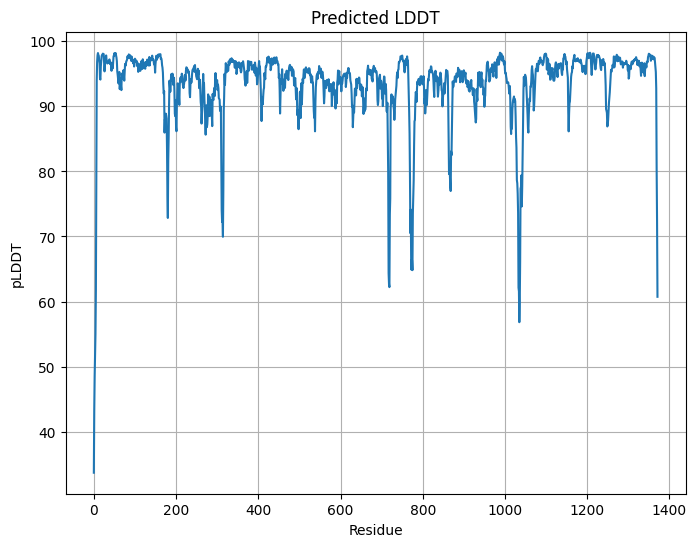

In [8]:
#@title Show confidences

from unifold.colab.plot import colab_plot_confidence

colab_plot_confidence(
    best_result=best_result,
    output_dir=output_dir,
    show_sidechains=show_sidechains,
    dpi=dpi,
    cutoff=crosslink_distance_cutoff,
)


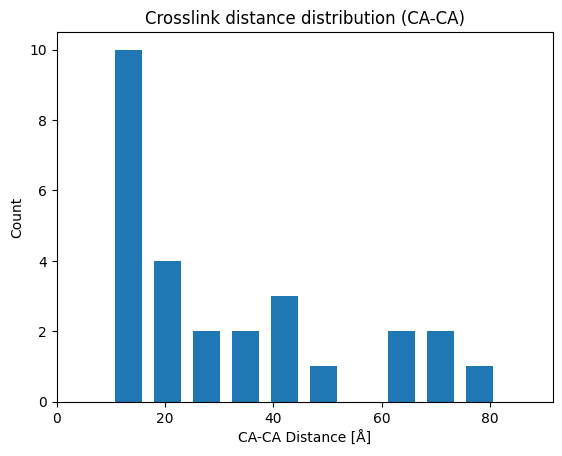

In [9]:
#@title Show crosslink distance distribution

from unifold.colab.plot import plot_distance_distribution

plot_distance_distribution(
    best_result=best_result,
    output_dir=output_dir
)


In [10]:
#@title Download the prediction
#@markdown **The content of zip file**:
#@markdown 1. PDB formatted structures
#@markdown 2. Json file of the model quality (pLDDT and pTM for multimer)
#@markdown 2. Plots of the best model quality (pLDDT and PAE for multimer)

from google.colab import files
import glob

file_lists = glob.glob(os.path.join(output_dir, "*.pdb"))
file_lists += glob.glob(os.path.join(output_dir, "*.json"))
file_lists += glob.glob(os.path.join(output_dir, "*.svg"))

!zip -q {target_id}.zip {" ".join(file_lists)}
files.download(f'{target_id}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>